## Deploy Models for Inference

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Deploy pretrained model to SageMaker Endpoint](#Deploy-pretrained-model-to-SageMaker-Endpoint)
    1. [Model Config](#Model-Config)
    2. [Option 1: Serverless Inference](#Option-1:-Serverless-Inference)
        1. [Serverless Inference Deploy Config](#Serverless-Inference-Deploy-Config)
        2. [Serverless Inference Deployment](#Serverless-Inference-Deployment)
    3. [Option 2: Real-time Inference](#Option-2:-Real-time-Inference)
        1. [Real-time Inference Deployment](#Real-time-Inference-Deployment)
5. [Run Inference on Deployed Endpoint](#Run-Inference-on-Deployed-Endpoint)
    1. [Create Predictor from Inference Endpoint](#Create-Predictor-from-Inference-Endpoint)
    2. [Get trained Classes Info](#Get-trained-Classes-Info)
    3. [Download sample test images from S3 for inference](#Download-sample-test-images-from-S3-for-inference)
    4. [Get Predictions from local images](#Get-Predictions-from-local-images)
6. [Clean Up](#Clean-Up)

# Introduction
After you build and train your models, you can deploy them to get predictions. 

SageMaker supports multiple deployment types for customers to choose from, based on the requirements, like Real-time inference, Serverless inference, Asynchronous inference, and Batch transform. 

To learn more about deploying models for inference using SageMaker refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html).  

** Note: This Notebook was tested on Data Science Kernel for SageMaker Studio**

## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

- Prepare our model for deployment (use the model from the previous modules)
- Familiarity with Python and numpy
- Basic familiarity with AWS S3.
- Basic understanding of AWS Sagemaker.
- Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.
- SageMaker Studio is preferred for the full UI integration

## Setup

Setting up the environment, load the libraries, and define the parameters for the entire notebook.


In [1]:
!pip install -U sagemaker s3fs --quiet # Ensure latest version of SageMaker is installed

ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.


In [2]:
%reset -f

In [3]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket() # or use your own custom bucket name
prefix = "cv-sagemaker-immersionday" # or define your own prefix

TF_FRAMEWORK_VERSION = '2.4.1'
ENDPOINT_INSTANCE_TYPE = 'ml.c5.4xlarge'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Deploy pretrained model to SageMaker Endpoint

### Model Config

You can use the bird model created from the previous modules (ref. [02_training/training.ipynb](../02_training/training.ipynb)), by executing the cell below.



In [ ]:
bird_model_path = f's3://{bucket}/{prefix}/outputs/model/model.tar.gz'
print(f'bird_model_path: {bird_model_path}')

## Choose the deployment option for Inference

Run either Option 1 or Option 2

## Option 1: Serverless Inference

Amazon SageMaker Serverless Inference is a new inference option that enables you to easily deploy machine learning models for inference without having to configure or manage the underlying infrastructure. 

Simply select the serverless option when deploying your machine learning model, and Amazon SageMaker automatically provisions, scales, and turns off compute capacity based on the volume of inference requests. 

With SageMaker Serverless Inference, you pay only for the duration of running the inference code and the amount of data processed, not for idle time. For more information on how Serverless Inference works visit [here](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html). 

### Serverless Inference Deploy Config

This object specifies configuration related to serverless endpoint. Use this configuration when trying to create serverless endpoint and make serverless inference

Initialize a ServerlessInferenceConfig object for serverless inference configuration.


In [ ]:
import sagemaker.serverless as Serverless

serverless_inf_config = Serverless.ServerlessInferenceConfig(
    memory_size_in_mb=4096, 
    max_concurrency=5)

### Serverless Inference Deployment

Deploy the Model to a serverless endpoint and return a Predictor object to make serverless inference.

In [ ]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=bird_model_path, 
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(serverless_inference_config=serverless_inf_config)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

The endpoint name will be displayed in the previous cell output when it's active and can also be seen under the SageMaker Resources option which is on the left side bar of the Studio as well. You will need it in the next section to create predictor from Inference endpoint

![Active Endpoint](statics/active-sagemaker-endpoints.png)

## Option 2: Real-time Inference

### Real-time Inference Deployment

Real-time inference is ideal for inference workloads where you have real-time, interactive, low latency requirements. You can deploy your model to SageMaker hosting services and get an endpoint that can be used for inference. These endpoints are fully managed and support autoscaling.

Deploy the Model to a real-time endpoint and return a Predictor object to make inference.

In [ ]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=bird_model_path,
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(initial_instance_count=1, instance_type=ENDPOINT_INSTANCE_TYPE)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

The endpoint name will be displayed in the previous cell output when it's active and can also be seen under the SageMaker Resources option which is on the left side bar of the Studio as well. You will need it in the next section to create predictor from Inference endpoint

![Active Endpoint](statics/active-sagemaker-endpoints.png)

## Run Inference on Deployed Endpoint

### Create Predictor from Inference Endpoint

After the deployment is complete in the above step, capture the endpoint name from SageMaker console and input below in the Predictor config. We could have reused the predictor from above step that is returned after deploy is complete, but this section shows how you can create a predictor from an existing endpoint for inference.

In [4]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

#Update the below variable with your endpoint name from previous cell output
tf_endpoint_name='tensorflow-inference-2024-03-01-12-12-36-289'

serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer(accept='application/json')

predictor = Predictor(endpoint_name=tf_endpoint_name,serializer = serializer,deserializer = deserializer )

### Get trained Classes Info

In [5]:
import cv_utils

classes_file = f"s3://{bucket}/{prefix}/full/data/classes.txt"
classes = [13, 17, 35, 36, 47, 68, 73, 87]

possible_classes= cv_utils.get_classes_as_list(classes_file,classes)

possible_classes

['013.Bobolink',
 '017.Cardinal',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '047.American_Goldfinch',
 '068.Ruby_throated_Hummingbird',
 '073.Blue_Jay',
 '087.Mallard']

### Download sample test images from S3 for inference

This cell downloads a random number of images (specified by value of 'n') from 'test' data set and use them for running inferences using our model.

In [6]:
sample_images = cv_utils.get_n_random_images(bucket,prefix=f'{prefix}/outputs/test',n=3)

local_paths = cv_utils.download_images_locally(bucket,sample_images)
print(local_paths)

['./inference-test-data/Ruby_Throated_Hummingbird_0117_58092.jpg', './inference-test-data/Northern_Flicker_0129_29022.jpg', './inference-test-data/Ruby_Throated_Hummingbird_0077_57858.jpg']


### Get Predictions from local images

This cell will make use of the "predict_bird_from_file" utility function in order to both visualize the test image and respective bird class predicted by the model with its correspondent confidence score.

./inference-test-data/Ruby_Throated_Hummingbird_0117_58092.jpg


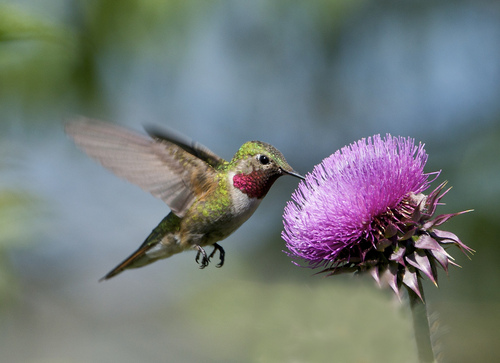

Class: 068.Ruby_throated_Hummingbird, confidence: 0.79
./inference-test-data/Northern_Flicker_0129_29022.jpg


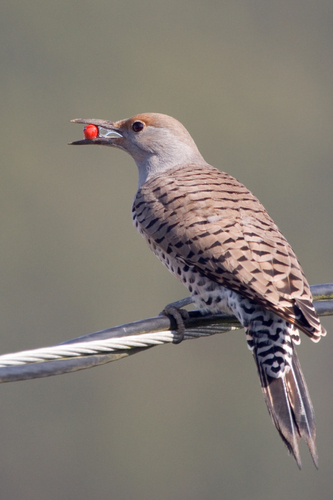

Class: 036.Northern_Flicker, confidence: 1.00
./inference-test-data/Ruby_Throated_Hummingbird_0077_57858.jpg


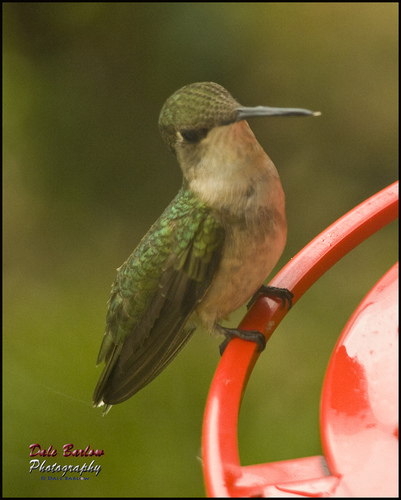

Class: 068.Ruby_throated_Hummingbird, confidence: 1.00


In [7]:
for inputfile in local_paths:
    print(inputfile)
    cv_utils.predict_bird_from_file(inputfile,predictor,possible_classes)